In [ ]:
!echo "hello"

# load and view data

In [2]:
from __future__ import print_function, division
from collections import OrderedDict
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time


x = np.load('data/gsn_img_uint8.npy')
y = np.load('data/gsn_msk_uint8.npy')

x_test = np.load('data/test_gsn_image.npy')
y_test = np.load('data/test_gsn_mask.npy')

In [3]:
print(x.shape, y.shape)

(2000, 128, 128, 3) (2000, 128, 128, 1)


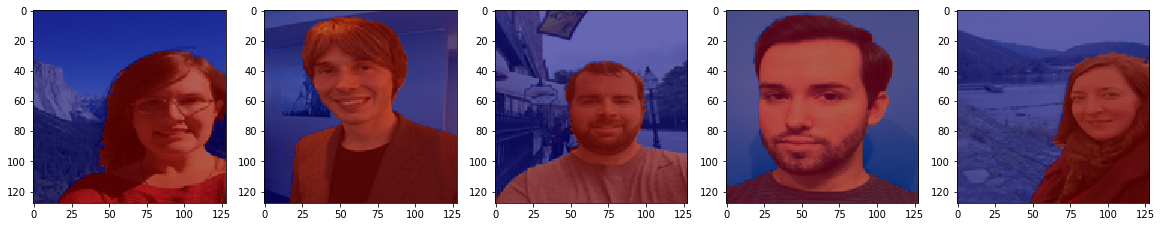

In [4]:
from matplotlib import pyplot as plt

def imshow(img):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(img,aspect='auto')
    plt.show()

def imshow_many(imgs):
    n = imgs.shape[0]
    if n < 20 :
        cols = 5
        rows = int((n+4)/5)
        fig = plt.figure(figsize=(cols * 4, rows * 4))
    else :
        cols = 10
        rows = int((n+9)/10)
        fig = plt.figure(figsize=(cols * 2, rows * 2))
    
    for i in range(n):
        sub = fig.add_subplot(rows, cols, i + 1)
        if(imgs.shape[3] == 1) :
            imgs = imgs.reshape((imgs.shape[0], imgs.shape[1], imgs.shape[2]))
        sub.imshow(imgs[i], interpolation='nearest')

def imshow_masked(samples):
    n = len(samples)
    if n < 20 :
        cols = 5
        rows = int((n+4)/5)
        fig = plt.figure(figsize=(cols * 4, rows * 4))
    else :
        cols = 10
        rows = int((n+9)/10)
        fig = plt.figure(figsize=(cols * 2, rows * 2))
    
    for i in range(n):
        sub = fig.add_subplot(rows, cols, i + 1)
        image = samples[i]['image']
        mask = samples[i]['mask']
        if torch.is_tensor(image) :
            image = image.permute(1,2,0)
        if torch.is_tensor(mask) :
            mask = mask.permute(1,2,0)
        mask = mask.reshape((mask.shape[0], mask.shape[1]))
        sub.imshow(image, interpolation='nearest')
        sub.imshow(mask, interpolation='nearest', cmap='jet', alpha=0.6)
    
start = 0
end = 5
samples = [{'image' : a, 'mask' : b} for a,b in zip(x[start:end], y[start:end])]
imshow_masked(samples)

# Transforms

In [5]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))
        resized_mask = transform.resize(mask, (new_h, new_w))
        mask = (resized_mask > 0.5).astype(resized_mask.dtype)

        return {'image': img, 'mask': mask}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        mask = mask[top: top + new_h,
                      left: left + new_w]

        return {'image': image, 'mask': mask}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        mask = mask.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'mask': torch.from_numpy(mask)}

# **Dataset**

In [6]:



class myDataset(Dataset):
    """Images and masks dataset."""

    def __init__(self, gsn_img, gsn_mask, transform=None):
        """
        Args:
            gsn_img (np.array): numpy array of images
            gsn_mask (np.array): numpy array of masks
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.images = gsn_img
        self.masks = gsn_mask
        self.transform = transform

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.images[idx]
        mask = self.masks[idx]

        sample = {'image': image, 'mask': mask}
        if self.transform:
            sample = self.transform(sample)
        return sample


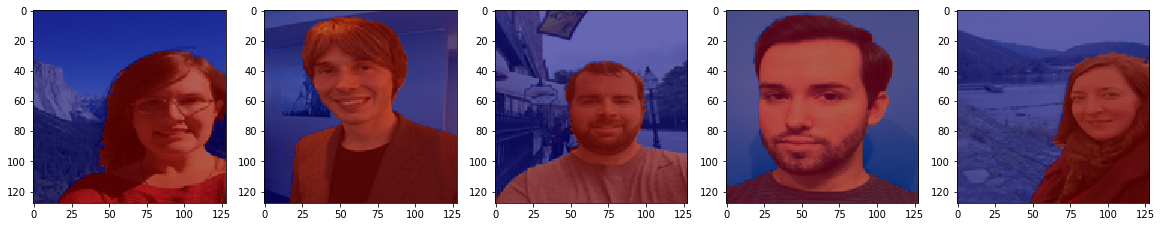

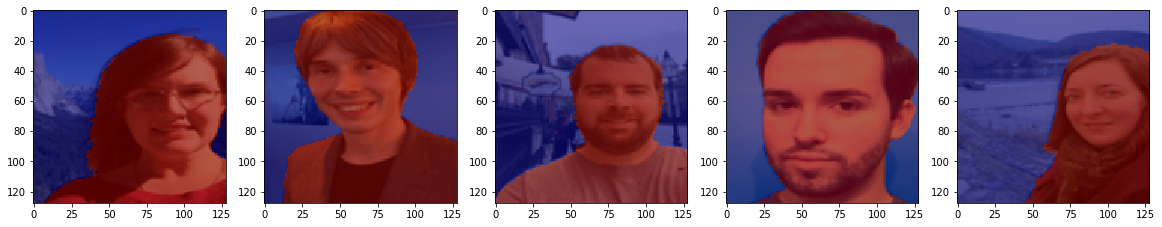

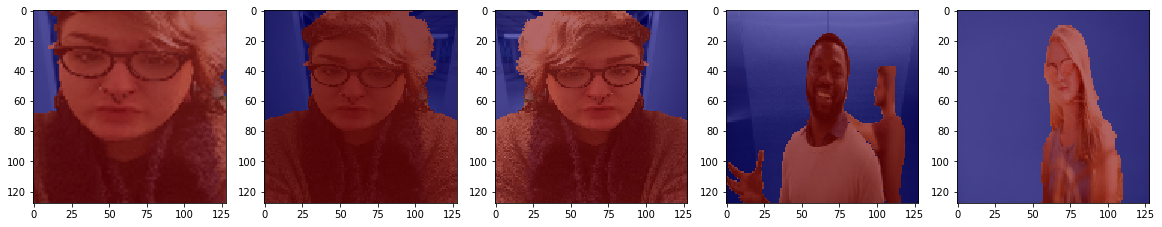

In [7]:
scale = Rescale(256)
crop = RandomCrop(127)
composed = transforms.Compose([Rescale(150),
                               RandomCrop(128),
                              ToTensor(),
                              ])

train_dataset = myDataset(x, y)
train_dataset_aug = myDataset(x, y, transform=composed)
test_dataset = myDataset(x_test, y_test, transform=ToTensor())

imshow_masked([train_dataset[i] for i in range(5)])

imshow_masked([train_dataset_aug[i] for i in range(5)])
imshow_masked([test_dataset[i] for i in range(5)])


In [8]:
trainloader = DataLoader(train_dataset_aug, batch_size=4,
                        shuffle=True, num_workers=4)
testloader = DataLoader(test_dataset, batch_size=4,
                        shuffle=False, num_workers=4)

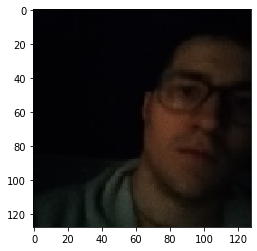

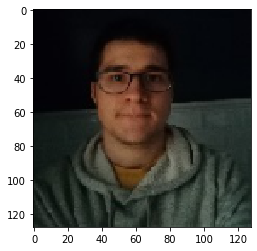

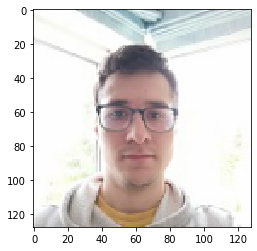

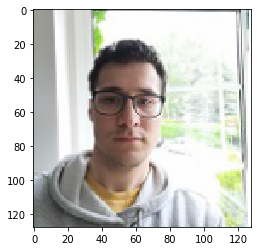

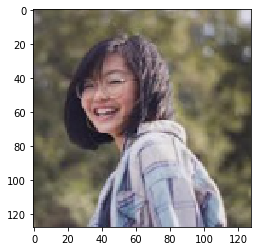

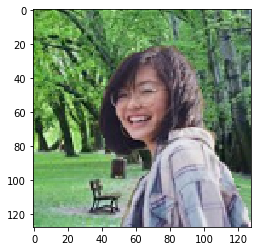

In [18]:
from matplotlib import image
ims = np.zeros((6,128,128,3))
for i in range(6):
    im = transform.resize(image.imread("my_data/{0}.jpg".format(i+1)), (128,128))
    ims[i] = (im)
    plt.imshow(im)
    plt.show()

In [23]:
np.save('my_dat.npy', ims)

# Network

In [ ]:

torch.set_default_tensor_type(torch.cuda.DoubleTensor)

class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=16):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

In [ ]:
epochs = 30
lr = 0.0001


def log_loss_summary(loss, step, prefix=""):
    print("epoch {} | {}: {}".format(step + 1, prefix + "loss", np.mean(loss)))



class DiceLoss(nn.Module):

    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1.0

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (
            y_pred.sum() + y_true.sum() + self.smooth
        )
        return 1. - dsc

def IOU(preds, truth):
    intersection = np.logical_and((preds > 0.5) == True,(truth > 0.5) == True).sum().item()
    union = (np.logical_or((preds > 0.5),(truth > 0.5))).sum().item()
    return intersection/union
    

imgs_log = []
    
unet = UNet(in_channels=3, out_channels=1)

def train_validate():
    device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0")
    
    unet.to(device)
    
    optimizer = optim.Adam(unet.parameters(), lr=lr)
    
    loss_train_log = []
    loss_valid_log = []
    IOU_log = []
    
    loss_train = []
    loss_valid = []
    
    dsc_loss = DiceLoss()
    
    step = 0
    
    for epoch in range(epochs):
        for phase in ["train", "valid"]:
            if phase == "train":
                unet.train()
            else:
                unet.eval()
    
            validation_pred = []
            validation_true = []
            IOU_avg_sum = 0
            batches = 0
    
            for i, data in enumerate(trainloader, 0):
                if phase == "train":
                    step += 1
                
                x = data['image']
                y_true = data['mask']
                
                
                
                x, y_true = x.to(device), y_true.to(device)
    
                optimizer.zero_grad()
    
                with torch.set_grad_enabled(phase == "train"):
                    y_pred = unet(x)
                    
                    loss = dsc_loss(y_pred, y_true)
                    
                    if phase == "valid":
                        loss_valid.append(loss.item())
                        y_pred_np = y_pred.detach().cpu().numpy()
                        validation_pred.extend(
                            [y_pred_np[s] for s in range(y_pred_np.shape[0])]
                        )
                        y_true_np = y_true.detach().cpu().numpy()
                        validation_true.extend(
                            [y_true_np[s] for s in range(y_true_np.shape[0])]
                        )
                        
                        imgs_log.append((y_true_np[0],y_pred_np[0]))
                        
                        batch_size = y_pred_np.shape[0]
                        IOU_batch = [IOU(y_pred_np[i],y_true_np[i]) for i in range(batch_size) ]
                        IOU_avg_sum += sum(IOU_batch)/batch_size
                        batches += 1
                        
                    if phase == "train":
                        loss_train.append(loss.item())
                        loss.backward()
                        optimizer.step()
    
            if phase == "train":
                loss_train_log.append(np.mean(loss_train))
                log_loss_summary(loss_train, epoch)
                loss_train = []

            if phase == "valid":
                iou = IOU_avg_sum/batches
                print("IOU=", iou)
                IOU_log.append(iou)
                loss_valid_log.append(np.mean(loss_valid))
                log_loss_summary(loss_valid, epoch, prefix="val_")
                loss_valid = []
    
    return loss_train_log,loss_valid_log, IOU_log
    

# Training

In [ ]:
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0")


unet = UNet(in_channels=3, out_channels=1)
unet.load_state_dict(torch.load('model30_noaug.mod'))
unet.to(device)
print("loaded")

# Results

In [ ]:
trained = []

device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0")
 
seqLoaderTrain = DataLoader(train_dataset_aug, batch_size=1,
                        shuffle=False, num_workers=4)


dsc_loss = DiceLoss()
    
with torch.set_grad_enabled(False):
    for i, data in enumerate(seqLoaderTrain, 0):
        if i % 500 == 499 :
            print('processed', i)
        x = data['image']
        y_true = data['mask']
        x, y_true = x.to(device), y_true.to(device)
        y_pred = unet(x)
        y_pred = y_pred.cpu()
        y_true = y_true.cpu()
        loss = IOU(y_pred, y_true)
        trained.append((loss, i))

In [ ]:
tested = []
test_dataset = myDataset(x_test, y_test, transform=composed)


seqLoaderTest = DataLoader(test_dataset, batch_size=1,
                        shuffle=False)

with torch.set_grad_enabled(False):
    for i, data in enumerate(seqLoaderTest, 0):
        if i % 500 == 499 :
            print('processed', i)
        x = data['image']
        y_true = data['mask']
        x, y_true = x.to(device), y_true.to(device)
        y_pred = unet(x)
        y_pred = y_pred.cpu()
        y_true = y_true.cpu()
        loss = IOU(y_pred, y_true)
        tested.append((loss, i))

In [ ]:
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0")

def show_compared(data):
    x = data['image']
    y_true = data['mask']
    x, y_true = x.to(device), y_true.to(device)
    y_pred = unet(x.reshape(1,x.shape[0], x.shape[1],x.shape[2]).double())
    y_pred_numpy = y_pred[0].cpu().detach().permute(1,2,0).numpy()
    
    y_true_np = y_true.detach().cpu().permute(1,2,0).numpy()
    
#     intersection = np.logical_and((y_pred_numpy > 0.5) == True,(y_true_np > 0.5) == False).astype('uint8')
    intersection = ((y_pred_numpy > 0.5) != (y_true_np > 0.5)).astype('uint8')
    
    pred_sample = {'image': x.detach().cpu(), 'mask':y_pred[0].detach().cpu()}
    
    diff = {'image': np.ones((128,128,3)).astype('uint8')*255, 'mask':intersection}
    imshow(data['image'].permute(1,2,0))
    imshow_masked([data,pred_sample, diff])

In [ ]:
trained_sorted = sorted(tested)
trained_sorted[-10:]

In [ ]:
[show_compared(train_dataset_aug[i]) for (_, i) in trained_sorted[-10:] ]

time.sleep(3)
print("worst")

[show_compared(train_dataset_aug[i]) for (_, i) in trained_sorted[:10] ]

In [ ]:
IOU(preds,trus)

In [ ]:
print(((preds > 0.5) ==  (trus > 0.5)).sum().item() / (128*128))

In [ ]:
torch.save(unet.state_dict(), 'model30.mod')